# Домашнее задание №4

**1. (20 баллов)**

Для папки Corel необходимо для каждого изображения, предварительно переведенного в HSV, посчитать гистограмму 
(шаг квантования выберите самостоятельно). 
После этого вычислить попарные расстояния между гистограммами с помощью метрик L2 и Хи-квадрат.
Отсортировать полученные пары и записать имена и расстояния в файл (для каждой метрики свой, 
т.е. в конечном итоге будет два файла) в формате:
$$
img\_name1 \hphantom aimg\_name23 \hphantom a 66.3$$
$$
img\_name5 \hphantom aimg\_name66 \hphantom a 77.1,
$$
где в каждой строчке записаны два имени файла и расстояние между изображениями, скрывающимися за этими именами.
Обратите внимание, что тут происходит некоторое определение расстояния между изображениями, 
а значит результат не должен быть совсем уж хаотичным, там есть группы похожих друг на друга изображений.

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pylab as plt
from scipy.spatial.distance import euclidean
%matplotlib inline

def show(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def show_gray(img):
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.set_axis_off()
    plt.imshow(img, cmap="gray")

In [2]:
dir_name = "datasets/datasets/Corel"
file_names = os.listdir(dir_name)
    
histograms = []
for file in file_names:
    img = cv2.imread(os.path.join(dir_name, file))
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
    norm_of_hist = np.linalg.norm(hist)
    histograms.append(hist/norm_of_hist)

In [3]:
chi_triplets = []
l2_triplets = []
for i in range(len(file_names)):
    for j in range(i+1, len(file_names)):
        chisqr_distance = cv2.compareHist(histograms[i], histograms[j], method = cv2.HISTCMP_CHISQR_ALT)
        l2_distance = np.linalg.norm(histograms[i] - histograms[j])
        chi_triplets.append((file_names[i], file_names[j], chisqr_distance))
        l2_triplets.append((file_names[i], file_names[j], l2_distance))

In [4]:
chi_triplets = sorted(chi_triplets, key=lambda x: x[2])
l2_triplets = sorted(l2_triplets, key=lambda x: x[2])

with open('Corel_Chi-squared.txt', 'w') as f:
    for i, j, dist in chi_triplets:
        print(i, j, dist, file=f)

with open('Corel_L2.txt', 'w') as f:
    for i, j, dist in l2_triplets:
        print(i, j, dist, file=f)   

**2. (20 баллов)**
Для папки leaves для каждого контура листа необходимо посчитать дескрипторы Фурье. После этого вычислить попарные расстояния между контурами (используйте метрику L2 для сравнения набора дескрипторов). Отсортировать полученные пары и записать имена в файл в формате, обозначенном в первом пункте.

In [5]:
dir_name = "datasets/datasets/leaves/"
file_names = os.listdir(dir_name)
imgs = [cv2.imread(os.path.join(dir_name, file), 0) for file in file_names]

In [6]:
def get_descriptor(img):
    # получим контур изображения
    ret, thresh = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
    contour = 255 - thresh
    contour = cv2.dilate(contour, np.ones((3, 3), np.uint8))
    # центр изображения
    cx = int(contour.shape[1] // 2)
    cy = int(contour.shape[0] // 2)
    c = (cx, cy)
    num_bins = 128 # количество рассматриваемых точек на контуре
    contour_points = []
    for i in range(num_bins):
        beam = np.zeros_like(contour) # луч из центра под углом t
        t = 2 * np.pi * i / num_bins
        cv2.line(beam, c, (int(cx + np.cos(t) * contour.shape[1]), int(cy - np.sin(t) * contour.shape[0])), 255, 2)
        nonzeros = np.nonzero(contour & beam) # точки пересечения контура и луча
        if len(nonzeros[0])>0:
            contour_points.append([nonzeros[1][0], nonzeros[0][0]])
        else:
            # если луч не пересек контур, значит контур проходит за краем изображения
            # добавим рамку
            tmp_img = np.zeros_like(contour)
            tmp_img = 255 - tmp_img
            tmp_img[1:-1, 1:-1] = contour[1:-1, 1:-1]
            nonzeros = np.nonzero(tmp_img & beam)
            contour_points.append([nonzeros[1][0], nonzeros[0][0]])

    l2_dists = [euclidean(point, c) for point in contour_points]
    fourier = np.fft.fft(l2_dists)
    descriptor = np.abs(fourier[1:]) / np.abs(fourier[0])

    return descriptor

In [7]:
descriptors = []
for i, img in enumerate(imgs):
    if i % 10 == 0:
        print(i)
    d = get_descriptor(img)
    descriptors.append(d)

0
10
20
30
40
50
60


In [9]:
from scipy.spatial.distance import euclidean
import itertools

l2_triplets = []
for i in range(len(file_names)):
    for j in range(i+1, len(file_names)):
        name1, name2 = file_names[i], file_names[j]
        l2_dist = euclidean(descriptors[i], descriptors[j])
        l2_triplets.append((name1, name2, l2_dist))
    
l2_triplets.sort(key=lambda x: x[2]) 
with open('Leaves_L2.txt', 'w') as f:
    for i, j, dist in l2_triplets:
        print(i, j, dist, file=f) 

Реализуте функцию, которая выводит на экран n самых лучших пар. 

In [10]:
def show_nearest(n, filename):
    dir_name = 'datasets/datasets/leaves/' if filename=='Leaves_L2.txt' else 'datasets/datasets/Corel/'
    with open(filename) as f:
        cnt = 0
        for line in f:            
            img1 = cv2.imread(dir_name + line.split(' ')[0])
            img2 = cv2.imread(dir_name + line.split(' ')[1])
            fig = plt.figure(figsize=(10, 200))
            cnt += 1
            a = fig.add_subplot(n, 2,  cnt)
            a.set_axis_off()
            plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)) 
            cnt += 1    
            a = fig.add_subplot(n, 2, cnt)
            a.set_axis_off()
            plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)) 
            if cnt >= n*2:
                break

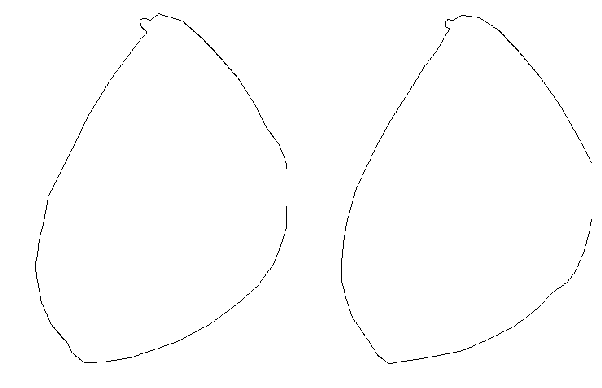

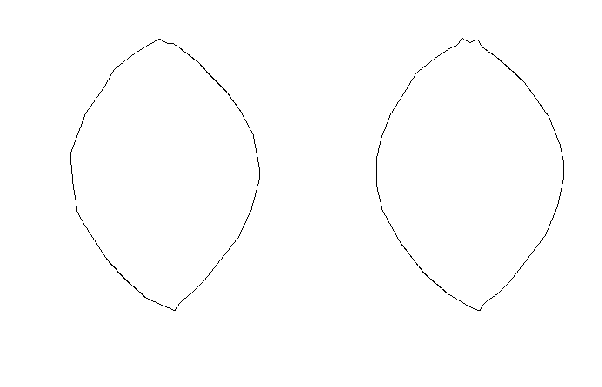

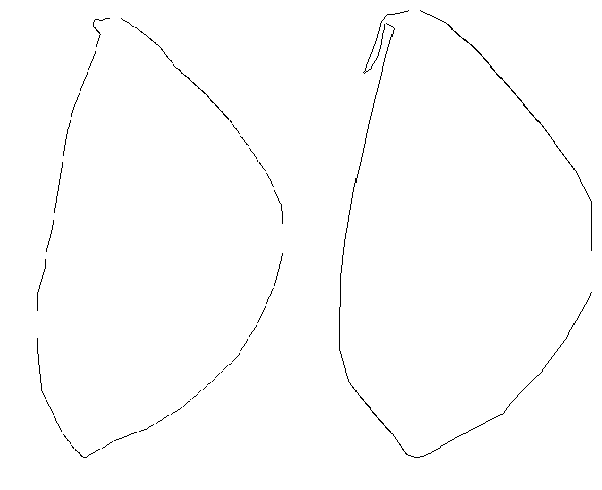

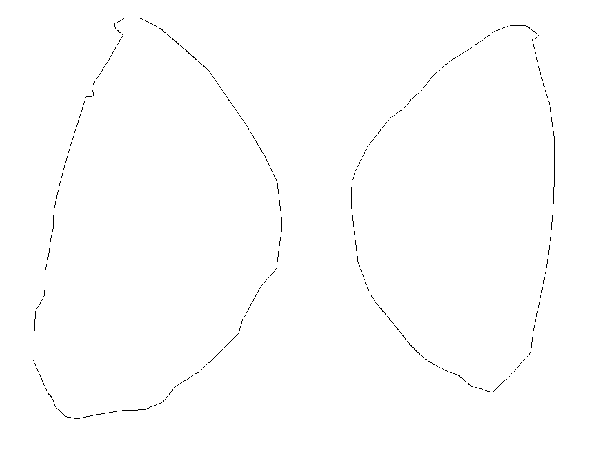

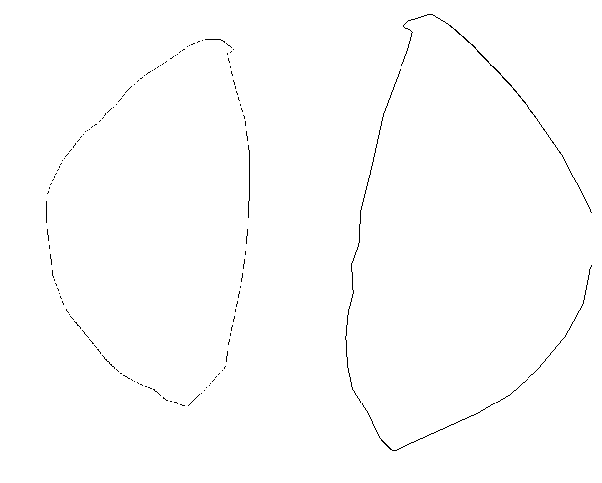

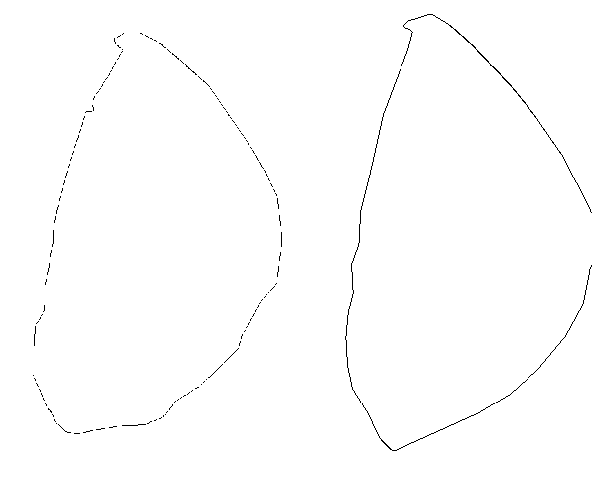

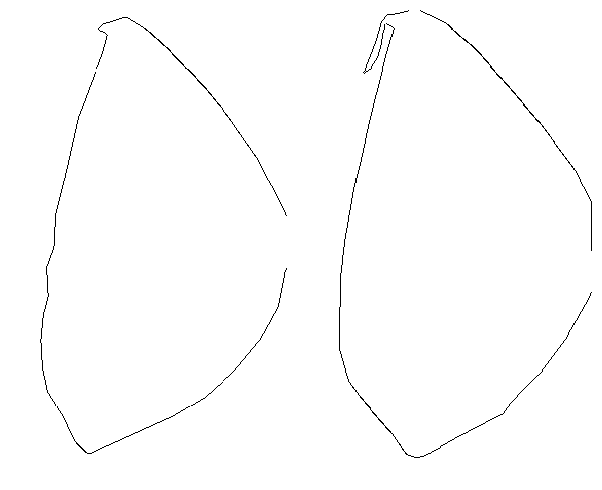

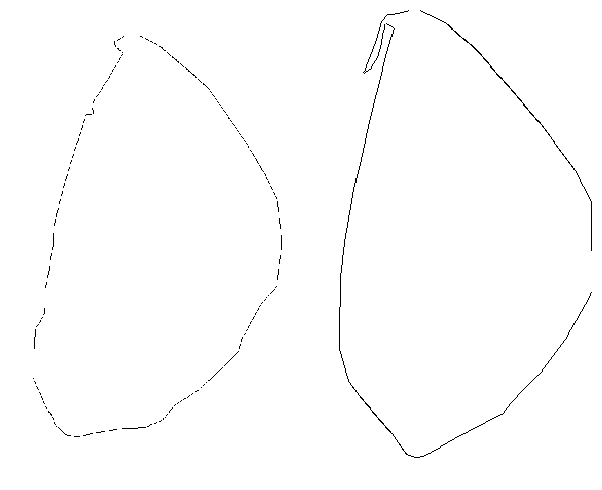

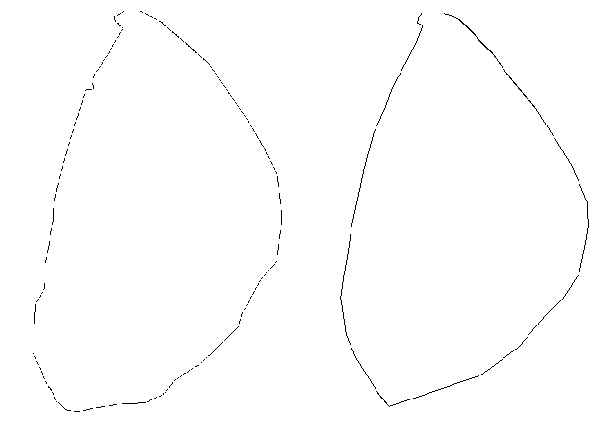

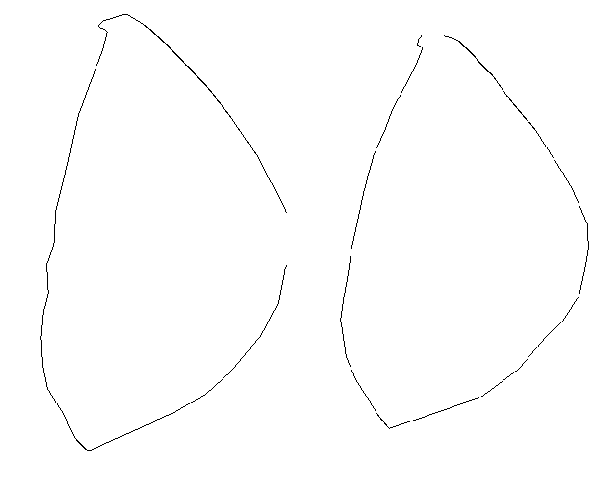

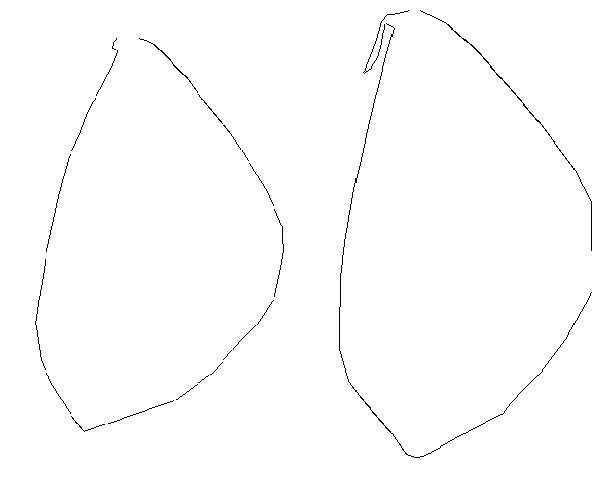

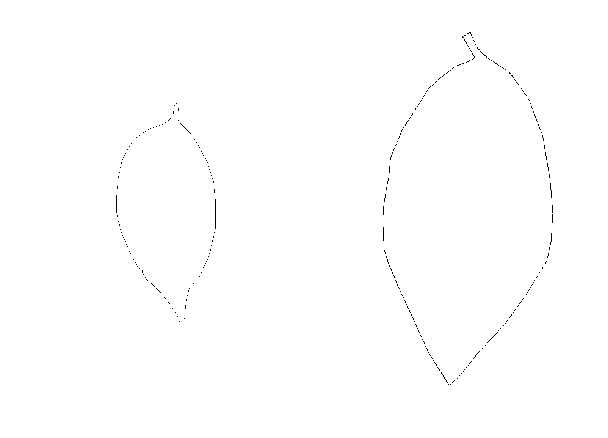

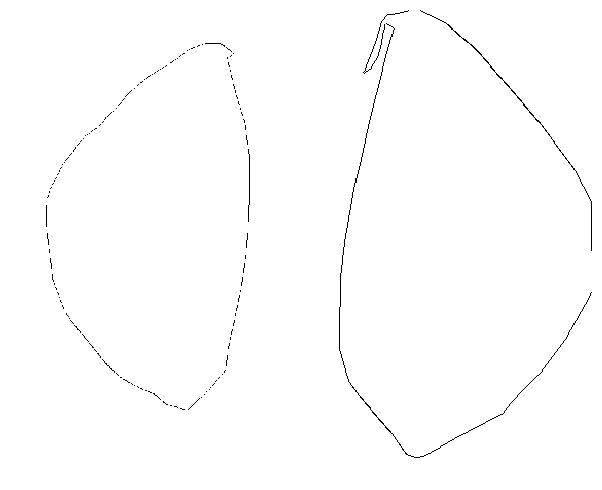

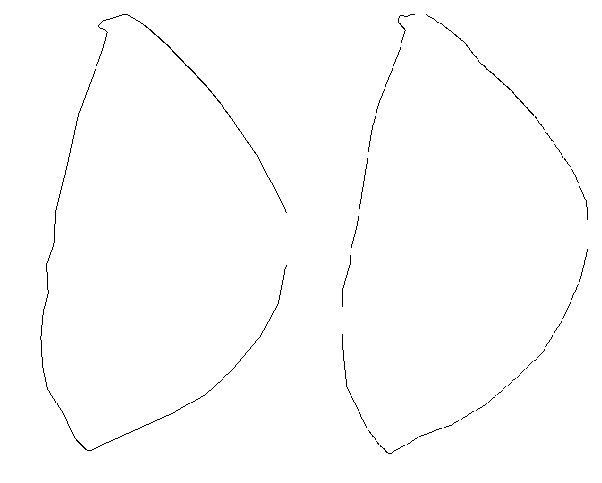

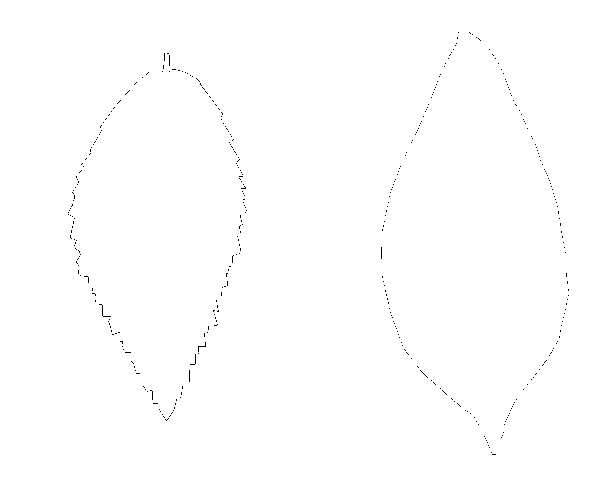

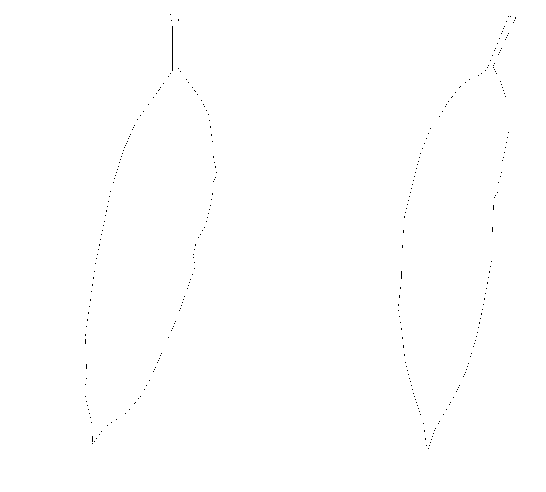

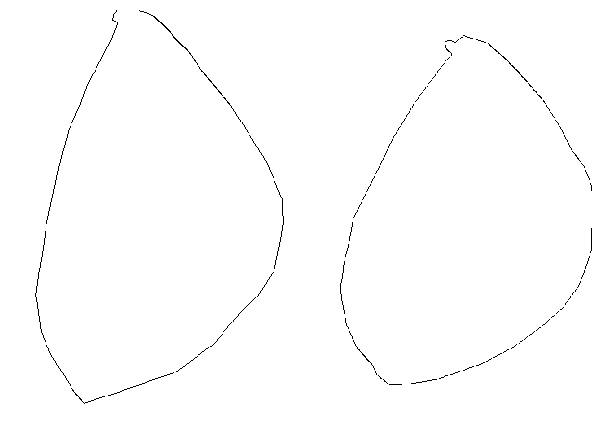

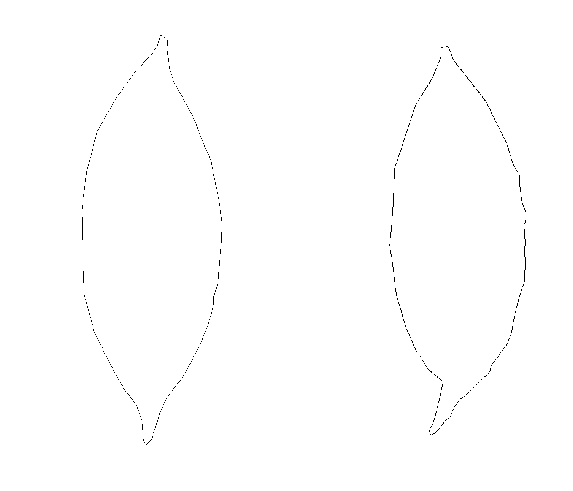

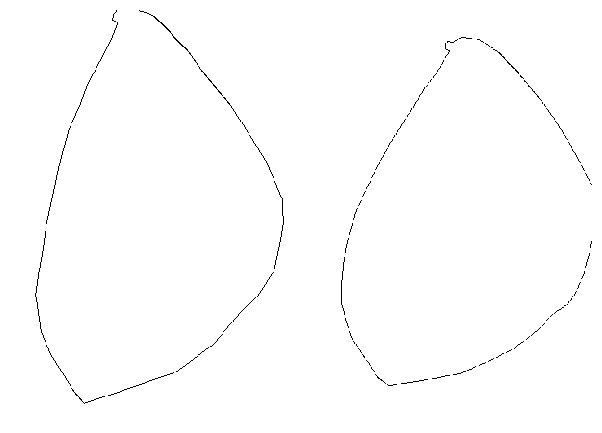

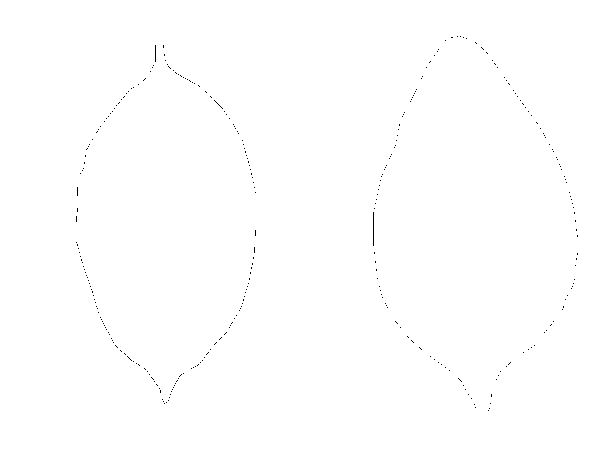

In [11]:
show_nearest(20,'Leaves_L2.txt')

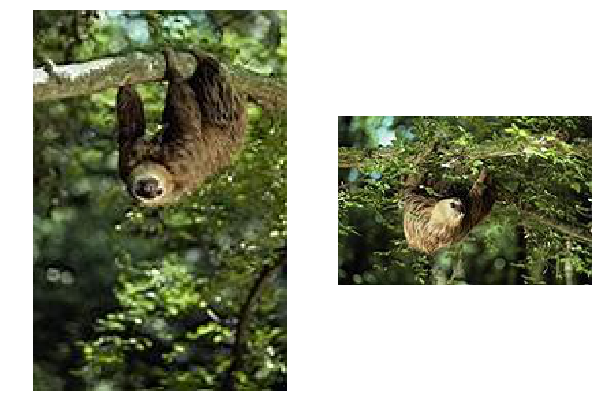

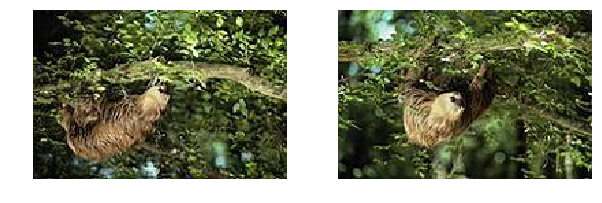

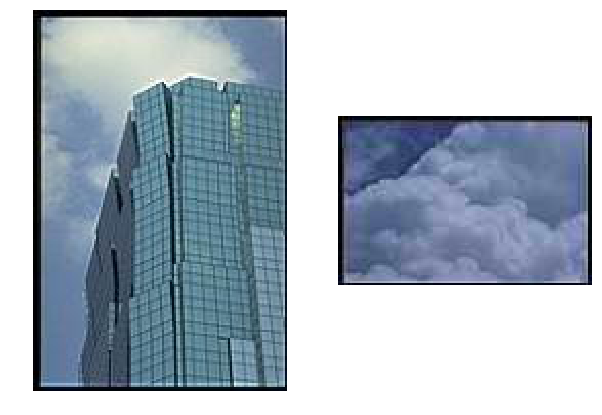

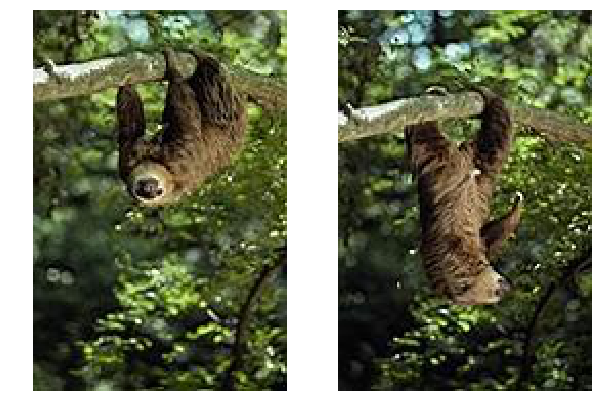

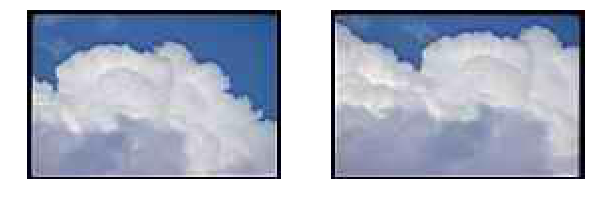

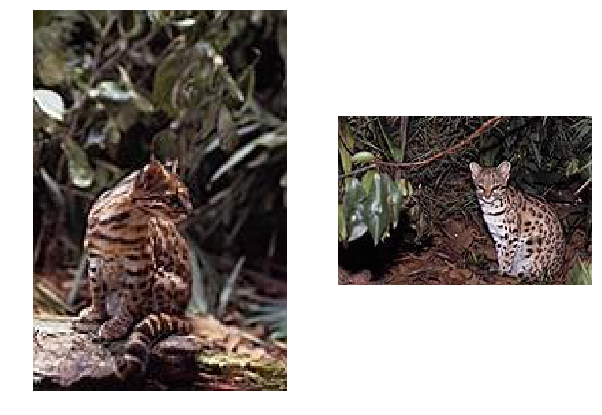

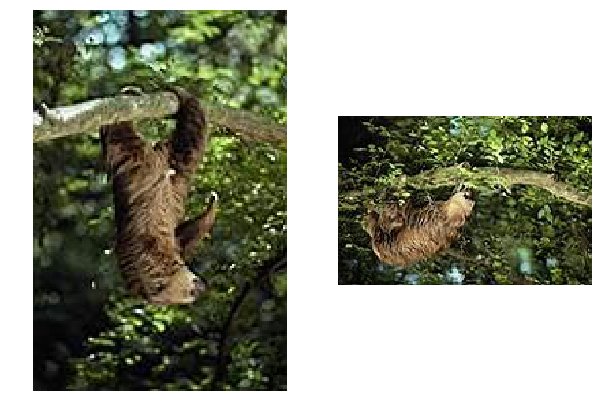

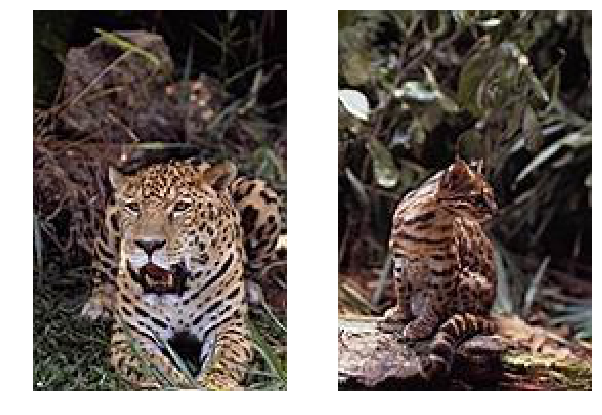

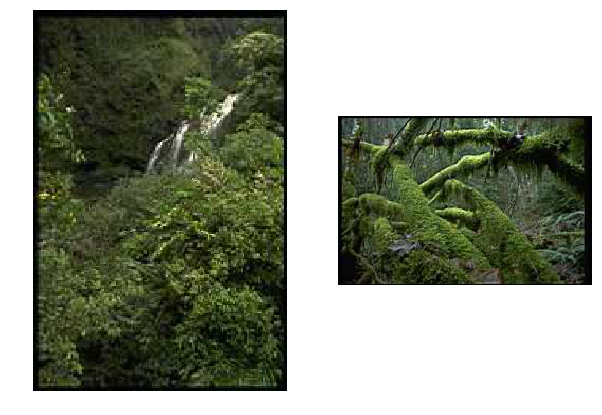

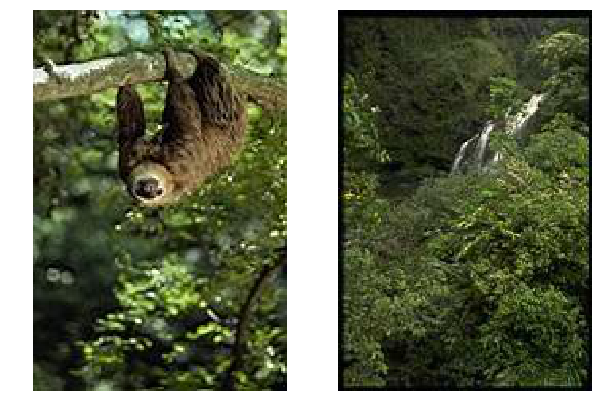

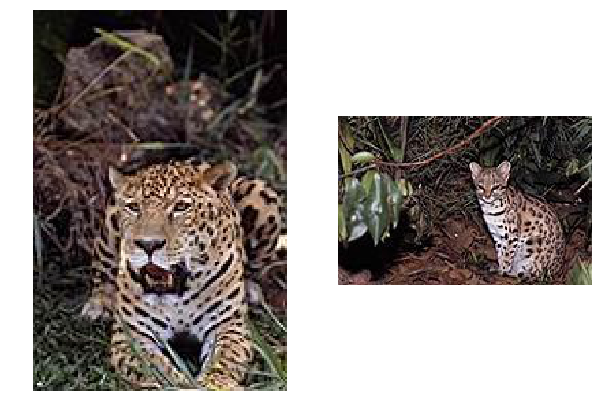

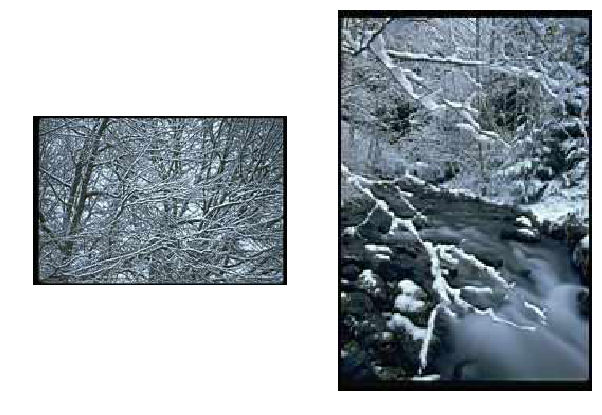

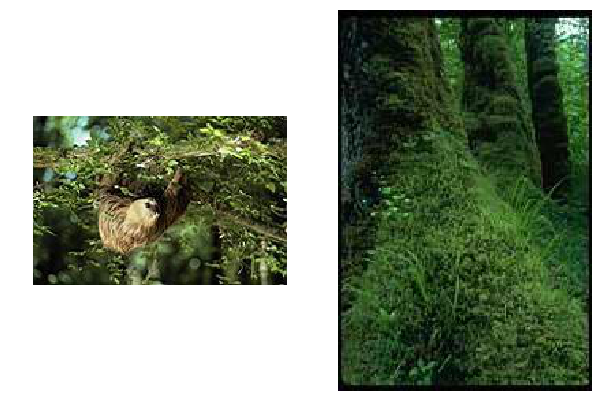

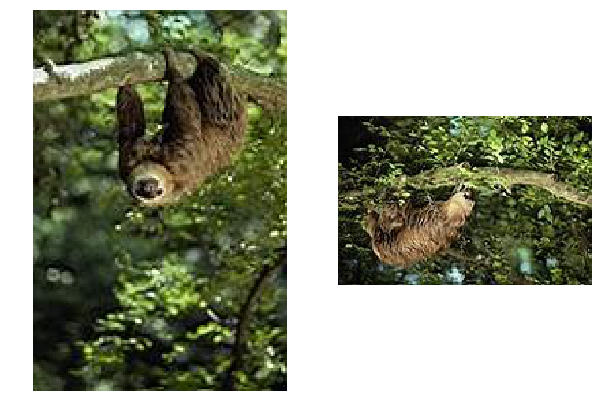

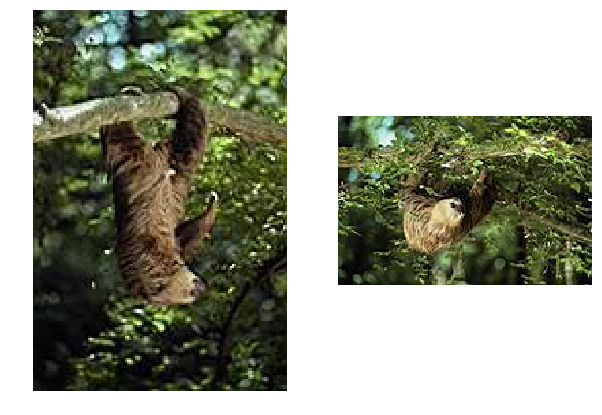

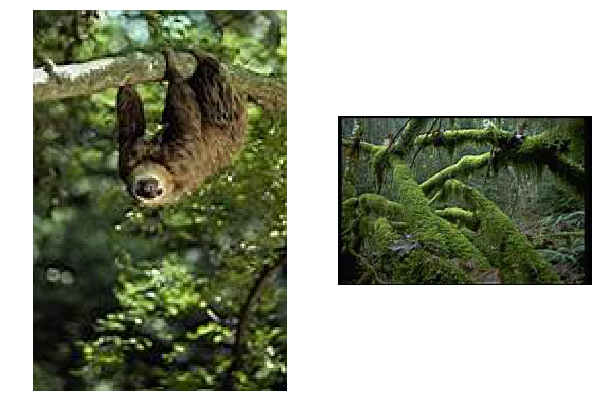

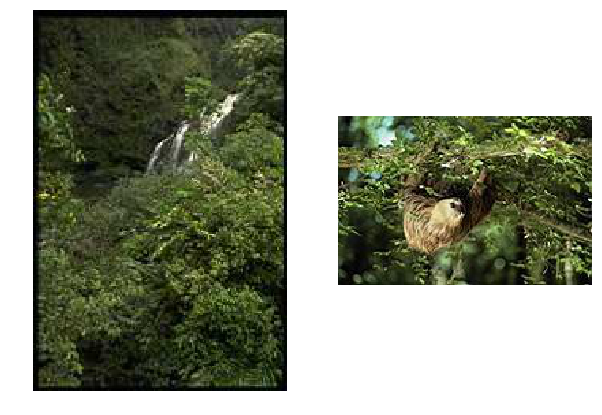

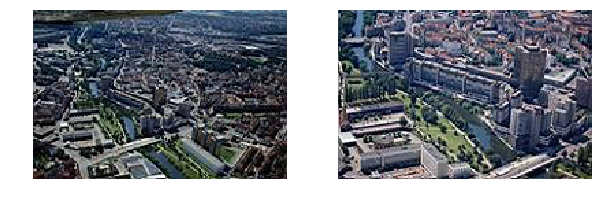

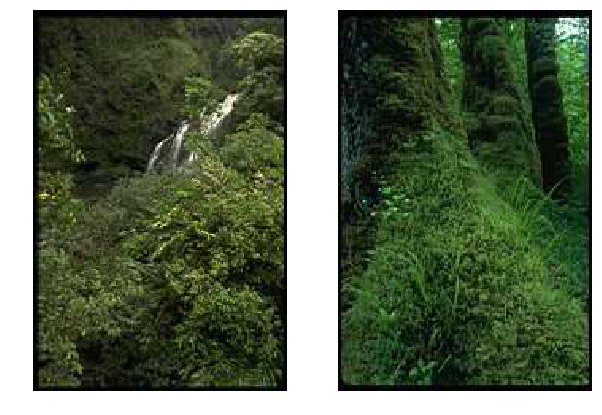

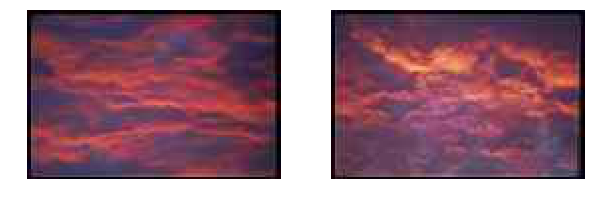

In [12]:
show_nearest(20,'Corel_L2.txt')

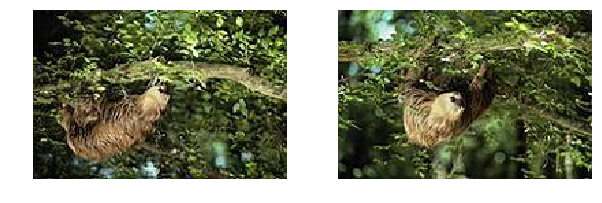

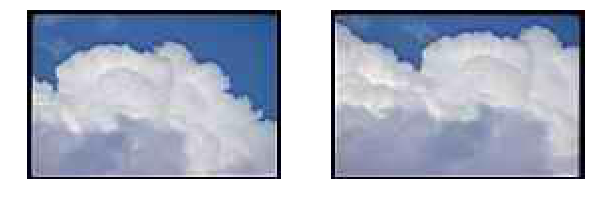

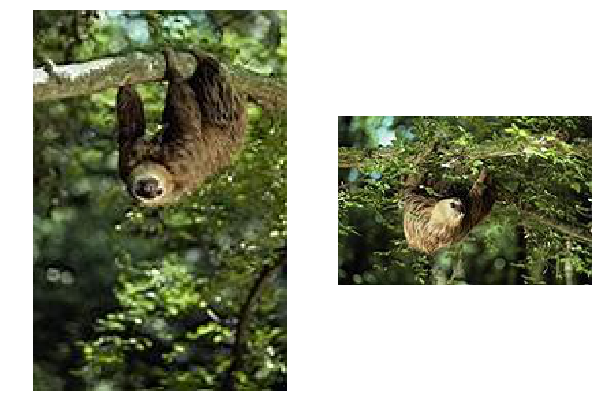

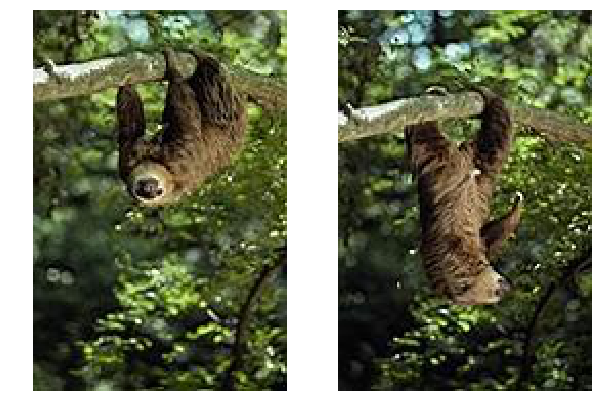

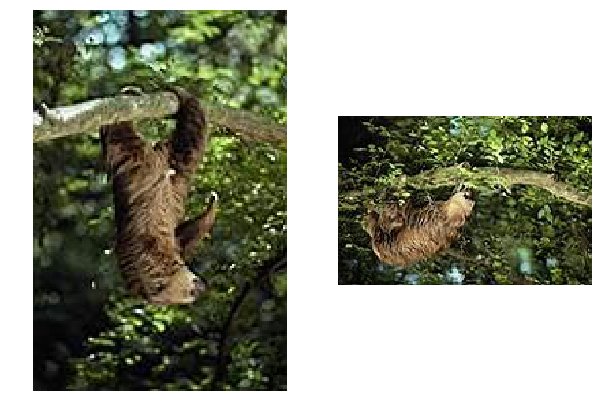

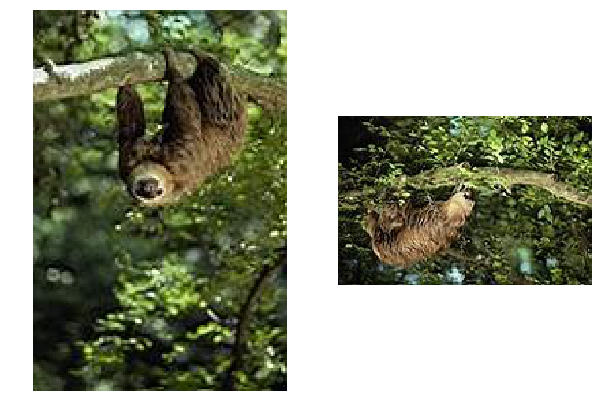

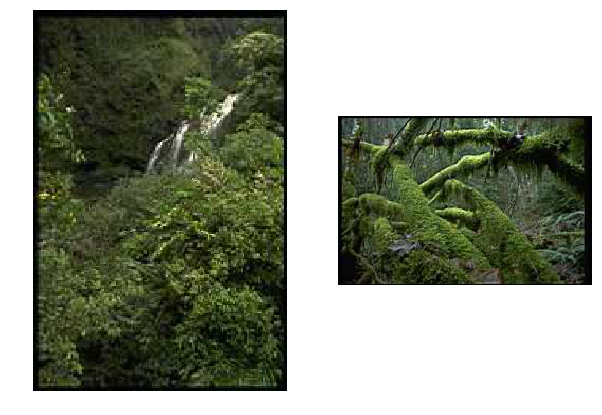

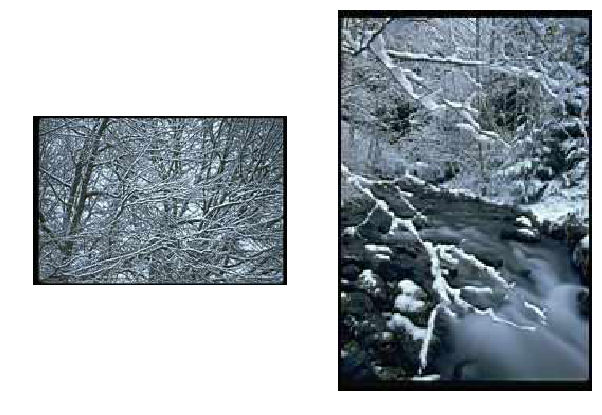

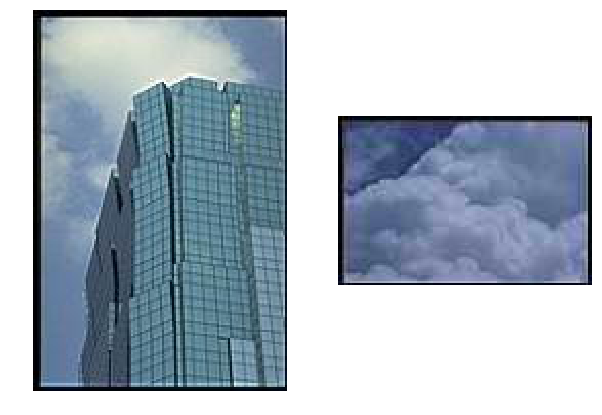

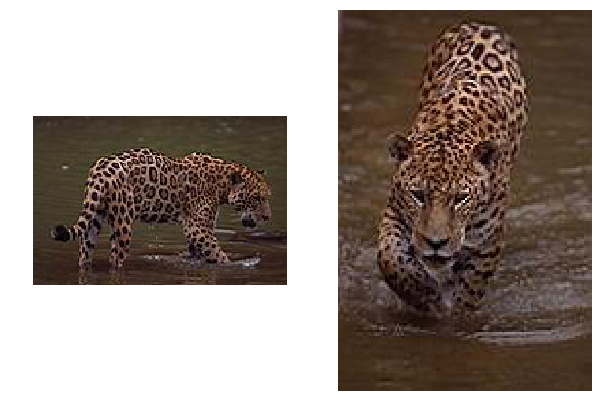

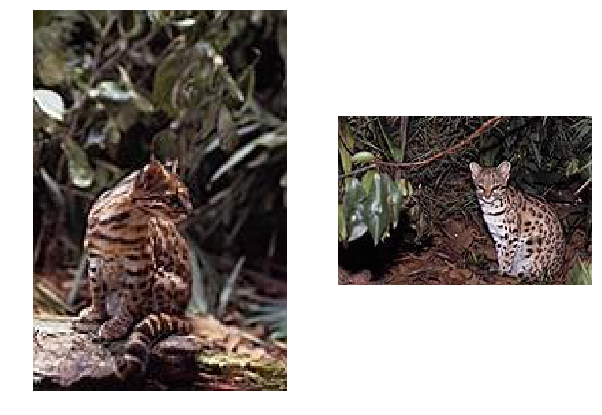

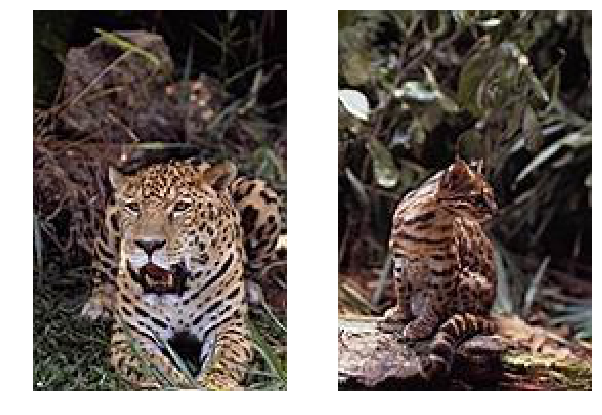

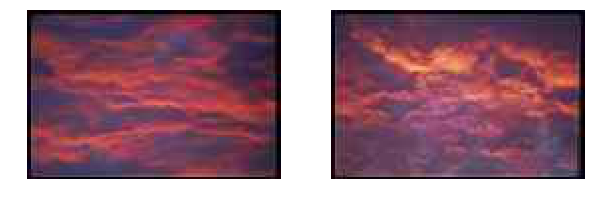

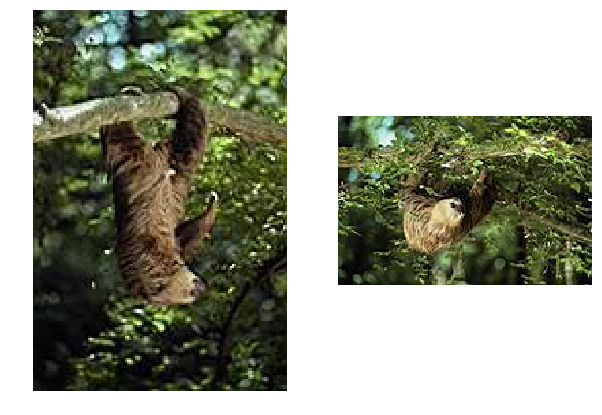

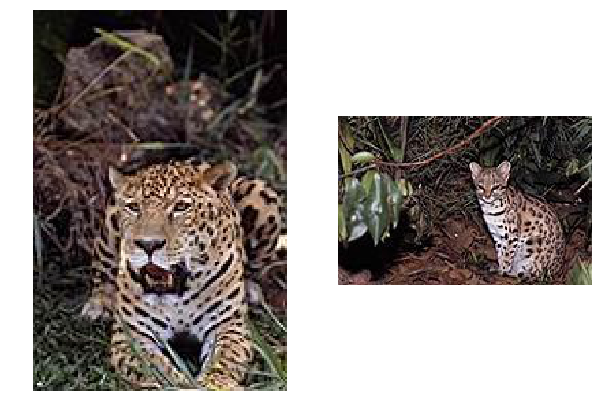

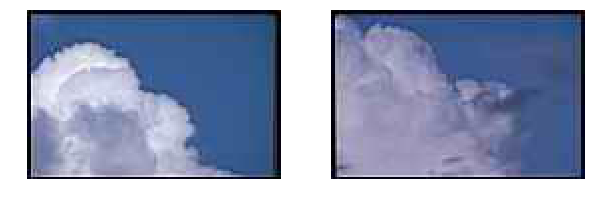

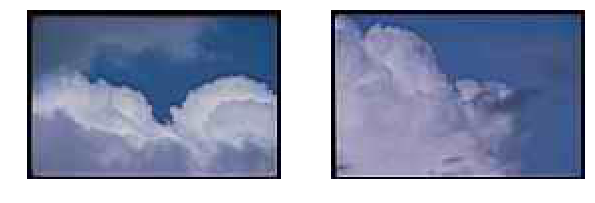

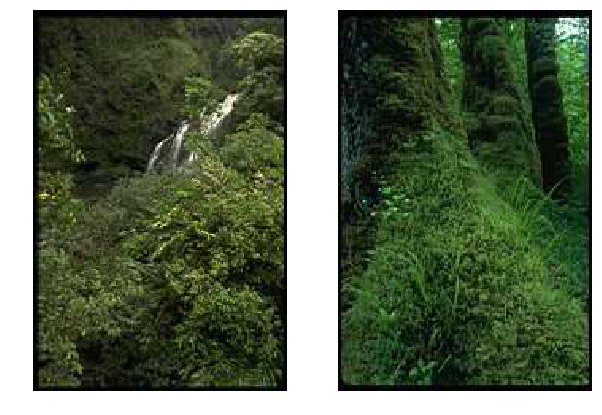

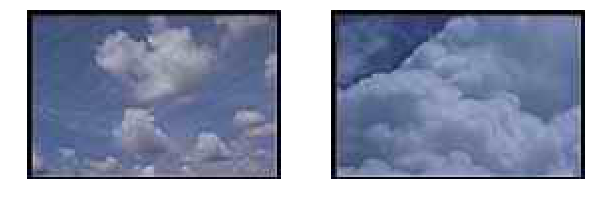

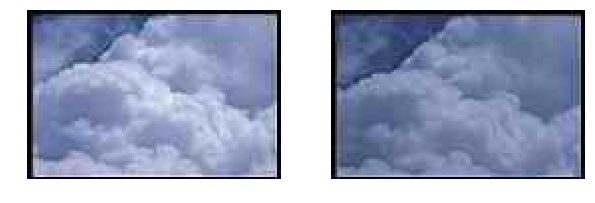

In [13]:
show_nearest(20,'Corel_Chi-squared.txt')